In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import networkx as nx
import igraph as ig

## Get bike crash and geometry info

In [2]:
bc_seg = gpd.read_file('bike_crash_seg_join.geojson')
bc_seg

,crashID,REPORTDATE,LATITUDE,LONGITUDE,MAJORINJURIES_BICYCLIST,MINORINJURIES_BICYCLIST,UNKNOWNINJURIES_BICYCLIST,FATAL_BICYCLIST,BICYCLISTSIMPAIRED,sev,...,straight_len,len,curve,betweenness,seg_geom,dist_to_road,dist_end1,dist_end2,intersection_dist,geometry
0,797,2012-05-04 10:28:00+00:00,38.905659,-77.029621,1,0,0,0,0,1,...,42.739471,42.761692,1.000520,681534.0,"LINESTRING (324009.951969 4308266.570204, 3240...",0.622744,0.900429,41.861262,0.900429,POINT (324010.556 4308265.657)
1,826,2011-11-09 05:00:00+00:00,38.901336,-77.034593,1,0,0,0,0,1,...,130.877235,132.081974,1.009205,20323514.0,"LINESTRING (323520.97828 4307673.88017, 323525...",0.008936,131.860131,0.221844,0.221844,POINT (323568.689 4307795.481)
2,863,2012-04-06 12:59:00+00:00,38.936279,-77.029725,1,0,0,0,0,1,...,190.274909,190.277957,1.000016,9582795.0,"LINESTRING (324072.80742 4311474.642134, 32407...",0.014837,189.612050,0.665908,0.665908,POINT (324077.203 4311664.2)
3,1023,2012-01-30 00:00:00+00:00,38.907244,-77.023979,0,1,0,0,0,0,...,65.403541,65.413156,1.000147,93480.0,"LINESTRING (324504.59933 4308431.006476, 32449...",0.332260,0.867673,64.545483,0.867673,POINT (324503.725 4308430.693)
4,1043,2012-06-27 04:00:00+00:00,38.924752,-77.067880,1,0,0,0,0,1,...,42.836291,42.809640,0.999378,30951.0,"LINESTRING (320746.554758 4310454.182052, 3207...",0.174258,7.610027,35.199613,7.610027,POINT (320740.858 4310459.23)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5252,338157,2025-10-18 05:58:00+00:00,38.911788,-77.048433,0,1,0,0,0,0,...,17.705917,17.833857,1.007226,17822.0,"LINESTRING (322391.700374 4308975.491798, 3223...",3.063281,6.749387,11.084470,6.749387,POINT (322394.492 4308982.358)
5253,338168,2025-10-18 18:59:00+00:00,38.917186,-77.026291,0,1,0,0,0,0,...,62.333279,84.661151,1.358201,115332.0,"LINESTRING (324353.871425 4309551.538737, 3243...",13.940403,25.619051,59.042100,25.619051,POINT (324327.758 4309538.55)
5254,338207,2025-10-16 20:10:00+00:00,38.903581,-76.994556,0,1,0,0,0,0,...,69.575137,71.352618,1.025548,1888.0,"LINESTRING (327051.49836 4307914.562348, 32704...",0.088838,55.367103,15.985515,15.985515,POINT (327046.28 4307967.941)
5255,338223,2025-10-16 20:40:00+00:00,38.863587,-76.991143,0,1,0,0,0,0,...,66.555136,66.559685,1.000068,42425.0,"LINESTRING (327222.642923 4303562.613595, 3272...",0.079268,45.844529,20.715156,20.715156,POINT (327245.387 4303522.811)


## DC subblock road data

In [9]:
sb = gpd.read_file(r'../DC_data/Roadway_SubBlock.geojson')
sb

,ROUTEID,FROMMEASURE,TOMEASURE,ROUTENAME,ROADTYPE,SUBBLOCKKEY,TOTALTRAVELLANES,TOTALPARKINGLANES,TOTALRAISEDBUFFERS,TOTALTRAVELLANEWIDTH,...,SMD_ID,ANC_ID,NETWORK_LOGICAL_END,AADT_COMBINATION,AADT_COMBINATION_YEAR,AADT_SINGLE_UNIT,AADT_SINGLE_UNIT_YEAR,OBJECTID,SHAPELEN,geometry
0,11000302,893.711670,944.862671,3RD ST NW,1,85c142bcb3d0019d55dd06f435923386,3,3,0,39,...,6E08,6E,None,NaN,NaN,NaN,NaN,9348470,0,"LINESTRING Z (-77.01518 38.89785 0, -77.01519 ..."
1,11000302,2494.385742,2531.276611,3RD ST NW,1,1fc875db24cc6dc749a21b6b2c91a7b4,2,3,0,16,...,4C07,4C,None,NaN,NaN,NaN,NaN,9348471,0,"LINESTRING Z (-77.0153 38.94003 0, -77.01531 3..."
2,11000302,2167.569580,2216.123535,3RD ST NW,1,a829b3d03a550301b9091050da7e31db,2,2,0,24,...,1B01,1B,None,NaN,NaN,NaN,NaN,9348472,0,"LINESTRING Z (-77.01574 38.91449 0, -77.01574 ..."
3,11000302,2079.489990,2111.326904,3RD ST NW,1,024154cc3185f8763181362cb4bc642f,3,1,0,44,...,5E03,5E,None,NaN,NaN,NaN,NaN,9348473,0,"LINESTRING Z (-77.01586 38.9137 0, -77.01582 3..."
4,11000302,4592.641602,4746.591797,3RD ST NW,1,0d6f557dac0ced632844676fe8f11922,2,2,0,24,...,4B06,4B,None,22.0,2020.0,63.0,2020.0,9348474,0,"LINESTRING Z (-77.01617 38.96132 0, -77.01617 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34918,64010532,881.278992,938.133972,ANACOSTIA RIVER TRAIL SW,6,f0171b9d7102bcfc8dcd4f6c63cbc1ff,0,0,0,0,...,8C01,8C,None,NaN,NaN,NaN,NaN,9385004,0,"LINESTRING Z (-77.00283 38.86711 0, -77.00283 ..."
34919,64010532,4858.782227,5297.869141,ANACOSTIA RIVER TRAIL SW,6,8f77b7912a871e36cd1bfd4f761310b7,0,0,0,0,...,8D07,8D,None,NaN,NaN,NaN,NaN,9385005,0,"LINESTRING Z (-77.01763 38.82824 0, -77.0175 3..."
34920,64010532,5297.869141,5516.471680,ANACOSTIA RIVER TRAIL SW,6,b3f8f13b4c8c9a5114e3887ca0240a7d,0,0,0,0,...,8D04,8D,None,NaN,NaN,NaN,NaN,9385006,0,"LINESTRING Z (-77.01737 38.82441 0, -77.01729 ..."
34921,64010532,233.360001,881.278992,ANACOSTIA RIVER TRAIL SW,6,60c5c3672b3865524252af7b2d885906,0,0,0,0,...,6D08,6D,None,NaN,NaN,NaN,NaN,9385007,0,"LINESTRING Z (-77.00946 38.86948 0, -77.00938 ..."


In [15]:
sb = sb.to_crs(sb.estimate_utm_crs())
sb

,ROUTEID,FROMMEASURE,TOMEASURE,ROUTENAME,ROADTYPE,SUBBLOCKKEY,TOTALTRAVELLANES,TOTALPARKINGLANES,TOTALRAISEDBUFFERS,TOTALTRAVELLANEWIDTH,...,SMD_ID,ANC_ID,NETWORK_LOGICAL_END,AADT_COMBINATION,AADT_COMBINATION_YEAR,AADT_SINGLE_UNIT,AADT_SINGLE_UNIT_YEAR,OBJECTID,SHAPELEN,geometry
0,11000302,893.711670,944.862671,3RD ST NW,1,85c142bcb3d0019d55dd06f435923386,3,3,0,39,...,6E08,6E,None,NaN,NaN,NaN,NaN,9348470,0,"LINESTRING Z (325243.866 4307371.344 0, 325244..."
1,11000302,2494.385742,2531.276611,3RD ST NW,1,1fc875db24cc6dc749a21b6b2c91a7b4,2,3,0,16,...,4C07,4C,None,NaN,NaN,NaN,NaN,9348471,0,"LINESTRING Z (325336.378 4312052.727 0, 325336..."
2,11000302,2167.569580,2216.123535,3RD ST NW,1,a829b3d03a550301b9091050da7e31db,2,2,0,24,...,1B01,1B,None,NaN,NaN,NaN,NaN,9348472,0,"LINESTRING Z (325235.645 4309218.55 0, 325236...."
3,11000302,2079.489990,2111.326904,3RD ST NW,1,024154cc3185f8763181362cb4bc642f,3,1,0,44,...,5E03,5E,None,NaN,NaN,NaN,NaN,9348473,0,"LINESTRING Z (325223.682 4309131.711 0, 325227..."
4,11000302,4592.641602,4746.591797,3RD ST NW,1,0d6f557dac0ced632844676fe8f11922,2,2,0,24,...,4B06,4B,None,22.0,2020.0,63.0,2020.0,9348474,0,"LINESTRING Z (325313.876 4314417.66 0, 325314...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34918,64010532,881.278992,938.133972,ANACOSTIA RIVER TRAIL SW,6,f0171b9d7102bcfc8dcd4f6c63cbc1ff,0,0,0,0,...,8C01,8C,None,NaN,NaN,NaN,NaN,9385004,0,"LINESTRING Z (326239.903 4303935.843 0, 326240..."
34919,64010532,4858.782227,5297.869141,ANACOSTIA RIVER TRAIL SW,6,8f77b7912a871e36cd1bfd4f761310b7,0,0,0,0,...,8D07,8D,None,NaN,NaN,NaN,NaN,9385005,0,"LINESTRING Z (324860.699 4299650.293 0, 324871..."
34920,64010532,5297.869141,5516.471680,ANACOSTIA RIVER TRAIL SW,6,b3f8f13b4c8c9a5114e3887ca0240a7d,0,0,0,0,...,8D04,8D,None,NaN,NaN,NaN,NaN,9385006,0,"LINESTRING Z (324873.581 4299224.71 0, 324880...."
34921,64010532,233.360001,881.278992,ANACOSTIA RIVER TRAIL SW,6,60c5c3672b3865524252af7b2d885906,0,0,0,0,...,6D08,6D,None,NaN,NaN,NaN,NaN,9385007,0,"LINESTRING Z (325670.523 4304211.453 0, 325677..."


In [18]:
sb.columns

Index(['ROUTEID', 'FROMMEASURE', 'TOMEASURE', 'ROUTENAME', 'ROADTYPE',
       'SUBBLOCKKEY', 'TOTALTRAVELLANES', 'TOTALPARKINGLANES',
       'TOTALRAISEDBUFFERS', 'TOTALTRAVELLANEWIDTH', 'TOTALCROSSSECTIONWIDTH',
       'TOTALPARKINGLANEWIDTH', 'TOTALTRAVELLANESINBOUND',
       'TOTALTRAVELLANESOUTBOUND', 'TOTALTRAVELLANESBIDIRECTIONAL',
       'TOTALTRAVELLANESREVERSIBLE', 'SUMMARYDIRECTION',
       'BIKELANE_PARKINGLANE_ADJACENT', 'BIKELANE_THROUGHLANE_ADJACENT',
       'BIKELANE_POCKETLANE_ADJACENT', 'BIKELANE_CONTRAFLOW',
       'BIKELANE_CONVENTIONAL', 'BIKELANE_DUAL_PROTECTED',
       'BIKELANE_DUAL_BUFFERED', 'BIKELANE_PROTECTED', 'BIKELANE_BUFFERED',
       'DOUBLEYELLOW_LINE', 'SECTIONFLAGS', 'LOC_ERROR', 'MIDMEASURE', 'AADT',
       'FHWAFUNCTIONALCLASS', 'HPMSID', 'HPMSSECTIONTYPE', 'ID', 'IRI',
       'IRI_DATE', 'NHSCODE', 'OWNERSHIP', 'PCI_CONDCATEGORY',
       'PCI_LASTINSPECTED', 'PCI_SCORE', 'SIDEWALK_IB_PAVTYPE',
       'SIDEWALK_IB_WIDTH', 'SIDEWALK_OB_PAVTYPE', 'SID

In [19]:
#connect to accident data
bc_seg = bc_seg.rename(columns={'index_right': 'index_right_bc_seg'})
bc_seg_sb = gpd.sjoin_nearest(bc_seg, sb, how="left", distance_col="dist_to_sb")
bc_seg_sb

,crashID,REPORTDATE,LATITUDE,LONGITUDE,MAJORINJURIES_BICYCLIST,MINORINJURIES_BICYCLIST,UNKNOWNINJURIES_BICYCLIST,FATAL_BICYCLIST,BICYCLISTSIMPAIRED,sev,...,SMD_ID,ANC_ID,NETWORK_LOGICAL_END,AADT_COMBINATION,AADT_COMBINATION_YEAR,AADT_SINGLE_UNIT,AADT_SINGLE_UNIT_YEAR,OBJECTID,SHAPELEN,dist_to_sb
0,797,2012-05-04 10:28:00+00:00,38.905659,-77.029621,1,0,0,0,0,1,...,2F05,2F,None,200.0,2020.0,1231.0,2020.0,9351230,0,0.154373
1,826,2011-11-09 05:00:00+00:00,38.901336,-77.034593,1,0,0,0,0,1,...,2C02,2C,None,NaN,NaN,NaN,NaN,9360131,0,0.226896
2,863,2012-04-06 12:59:00+00:00,38.936279,-77.029725,1,0,0,0,0,1,...,1A04,1A,None,107.0,2020.0,333.0,2020.0,9351299,0,0.228452
3,1023,2012-01-30 00:00:00+00:00,38.907244,-77.023979,0,1,0,0,0,0,...,2G04,2G,None,NaN,NaN,NaN,NaN,9357386,0,0.807391
4,1043,2012-06-27 04:00:00+00:00,38.924752,-77.067880,1,0,0,0,0,1,...,3C08,3C,None,NaN,NaN,NaN,NaN,9356935,0,0.472877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5252,338157,2025-10-18 05:58:00+00:00,38.911788,-77.048433,0,1,0,0,0,0,...,2B02,2B,None,15.0,2020.0,330.0,2020.0,9354858,0,0.740630
5253,338168,2025-10-18 18:59:00+00:00,38.917186,-77.026291,0,1,0,0,0,0,...,1B02,1B,None,NaN,NaN,NaN,NaN,9380724,0,14.745795
5254,338207,2025-10-16 20:10:00+00:00,38.903581,-76.994556,0,1,0,0,0,0,...,6A01,6A,None,NaN,NaN,NaN,NaN,9374712,0,0.219052
5255,338223,2025-10-16 20:40:00+00:00,38.863587,-76.991143,0,1,0,0,0,0,...,8A06,8A,None,NaN,NaN,NaN,NaN,9368641,0,0.279586


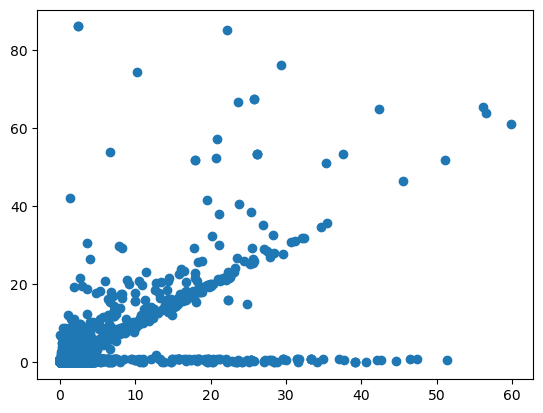

In [21]:
plt.scatter(bc_seg_sb['dist_to_road'], bc_seg_sb['dist_to_sb'])

I suspect some fo the values off th diagonal are when a road exists in one dataset but not the other

In [22]:
bc_seg_sb.to_file(r'../DC_data/bc_seg_sb.geojson')

In [28]:
#bc_seg_sb['geometry'] = bc_seg_sb['geometry'].to_wkt()
bc_seg_sb.to_csv(r'../DC_data/bc_seg_sb.csv')